In [ ]:
import glob
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
from copy import deepcopy
import os

import tensorflow.compat.v2 as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, UpSampling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.models import load_model

from google.colab import files
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


데이터 로드 및 전처리


In [ ]:
PATH_TO_IMG = "/content/drive/MyDrive/vision/color_image/"
path_to_img_data = glob.glob(PATH_TO_IMG + "*jpg")
len(path_to_img_data)

43322

In [ ]:
TOTAL_SIZE = len(path_to_img_data)
TRAIN_RATIO = 0.8  # 훈련 데이터 비율
TEST_RATIO = 1 - TRAIN_RATIO  # 테스트 데이터 비율

TRAIN_SIZE = int(TOTAL_SIZE * TRAIN_RATIO)
TEST_SIZE = TOTAL_SIZE - TRAIN_SIZE

BATCH_SIZE = 128

IMG_HEIGHT = 224
IMG_WIDTH = 184

In [ ]:
def get_input(image_path):
    img = imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))

    return img


def get_output(image_path):
    img = imread(image_path)
    img = img/255.0
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    return img


def image_generator(files, batch_size = 64):

    tmp_x = deepcopy(files)

    while True:
        len_array = len(tmp_x)
        if len_array < batch_size:
          tmp_x = deepcopy(files)
          len_array = len(tmp_x)

        batch_index = np.random.choice(len_array, size=batch_size, replace=False)
        batch_paths = [tmp_x[index] for index in batch_index]
        tmp_x = np.delete(tmp_x, batch_index)
        batch_input  = []
        batch_output = []
        for input_path in batch_paths:
            input_img = get_input(input_path)
            output = get_output(input_path)
            batch_input.append(input_img)
            batch_output.append(output)
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )

        yield( batch_x, batch_y )

In [ ]:
train_gen = image_generator(path_to_img_data[:TRAIN_SIZE],BATCH_SIZE)
test_gen = image_generator(path_to_img_data[TRAIN_SIZE:TRAIN_SIZE+TEST_SIZE],BATCH_SIZE)

In [ ]:
plot_example_data = next(test_gen)

In [ ]:
plt.imshow(plot_example_data[0][1].reshape(IMG_HEIGHT,IMG_WIDTH),cmap='gray')
plt.show()

In [ ]:
plt.imshow(plot_example_data[1][1])
plt.show()

AutoEncoder Colorization 모델 학습

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2,
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 92, 64)       640       
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 92, 128)      73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 46, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 46, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 23, 256)       590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 23, 512)       1180160   
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 23, 256)       1

In [ ]:
STEP = TRAIN_SIZE//BATCH_SIZE
EPOCHS = 40
model.fit_generator(generator=train_gen,steps_per_epoch=STEP,epochs=EPOCHS)

<ipython-input-9-9740e384fc23>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_gen,steps_per_epoch=STEP,epochs=EPOCHS)


Epoch 1/40
270/270 [==============================] - 321s 1s/step - loss: 0.0183 - accuracy: 0.7148
Epoch 2/40
270/270 [==============================] - 273s 1s/step - loss: 0.0077 - accuracy: 0.6980
Epoch 3/40
270/270 [==============================] - 276s 1s/step - loss: 0.0071 - accuracy: 0.6972
Epoch 4/40
270/270 [==============================] - 277s 1s/step - loss: 0.0069 - accuracy: 0.6963
Epoch 5/40
270/270 [==============================] - 272s 1s/step - loss: 0.0067 - accuracy: 0.6965
Epoch 6/40
270/270 [==============================] - 276s 1s/step - loss: 0.0066 - accuracy: 0.6960
Epoch 7/40
270/270 [==============================] - 273s 1s/step - loss: 0.0064 - accuracy: 0.6951
Epoch 8/40
270/270 [==============================] - 280s 1s/step - loss: 0.0063 - accuracy: 0.6974
Epoch 9/40
270/270 [==============================] - 274s 1s/step - loss: 0.0062 - accuracy: 0.6992
Epoch 10/40
270/270 [==============================] - 275s 1s/step - loss: 0.0061 - accura

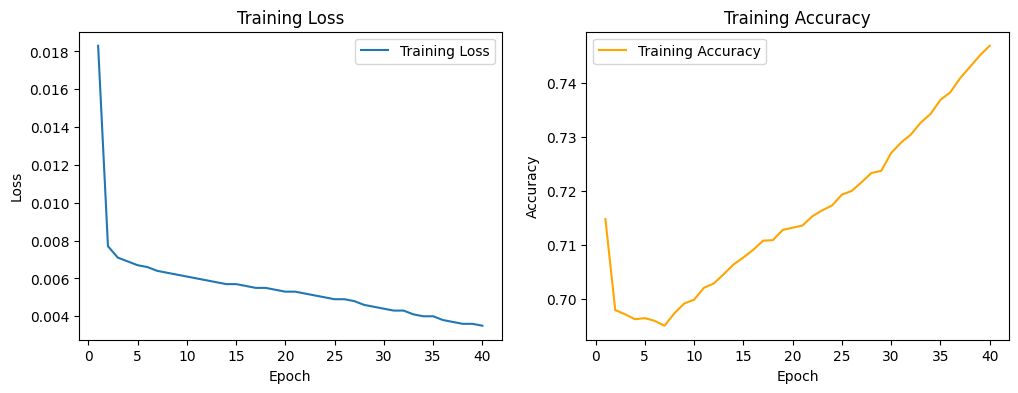

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 41)

# 로스 및 어큐러시 데이터
loss = [0.0183, 0.0077, 0.0071, 0.0069, 0.0067, 0.0066, 0.0064, 0.0063, 0.0062, 0.0061,
        0.0060, 0.0059, 0.0058, 0.0057, 0.0057, 0.0056, 0.0055, 0.0055, 0.0054, 0.0053,
        0.0053, 0.0052, 0.0051, 0.0050, 0.0049, 0.0049, 0.0048, 0.0046, 0.0045, 0.0044,
        0.0043, 0.0043, 0.0041, 0.0040, 0.0040, 0.0038, 0.0037, 0.0036, 0.0036, 0.0035]

accuracy = [0.7148, 0.6980, 0.6972, 0.6963, 0.6965, 0.6960, 0.6951, 0.6974, 0.6992, 0.6999,
            0.7021, 0.7029, 0.7046, 0.7064, 0.7077, 0.7091, 0.7108, 0.7109, 0.7128, 0.7132,
            0.7136, 0.7153, 0.7164, 0.7173, 0.7193, 0.7200, 0.7216, 0.7233, 0.7237, 0.7270,
            0.7289, 0.7304, 0.7326, 0.7342, 0.7368, 0.7382, 0.7408, 0.7429, 0.7450, 0.7468]

# 그래프로 시각화
plt.figure(figsize=(12, 4))

# loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, label='Training Accuracy', color='orange')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
test_img = next(test_gen)

colorization 모델 테스트셋 시각화

4/4 [==============================] - 2s 34ms/step


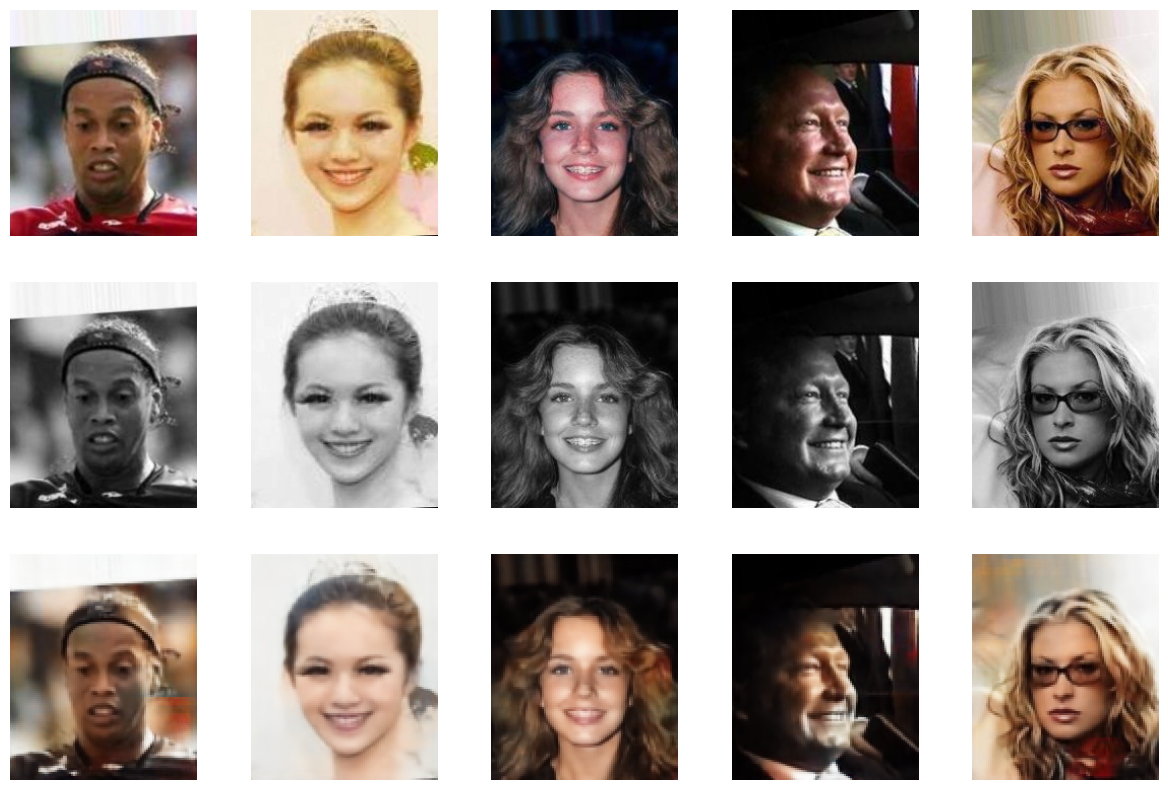

In [ ]:
predicted = model.predict(test_img[0])

n = 5
plt.figure(figsize=(15, 10))
for i in range(n):
    # display original
    plt.subplot(3, n, i + 1 )
    plt.imshow(test_img[1][i].reshape(IMG_HEIGHT, IMG_WIDTH, 3))
    plt.axis('off')


    # display grayscale
    plt.subplot(3, n, i + 1 + n )
    plt.imshow(test_img[0][i].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    plt.axis('off')

    # display predict
    plt.subplot(3, n, i + 1 + n * 2 )
    plt.imshow(predicted[i].reshape(IMG_HEIGHT, IMG_WIDTH, 3))
    plt.axis('off')

plt.show()

In [ ]:
#컬러화 모델 저장
model.save('colorization.h5')

GFPGAN 모델 로드

In [ ]:
#gfpgan 로드
%cd /content
!rm -rf GFPGAN
!git clone https://github.com/TencentARC/GFPGAN.git
%cd GFPGAN

!pip install basicsr
!pip install facexlib
!pip install -r requirements.txt
!python setup.py develop
!pip install realesrgan
!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P experiments/pretrained_models


/content
Cloning into 'GFPGAN'...
remote: Enumerating objects: 523, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 523 (delta 168), reused 153 (delta 153), pack-reused 313
Receiving objects: 100% (523/523), 5.37 MiB | 11.89 MiB/s, done.
Resolving deltas: 100% (279/279), done.
/content/GFPGAN
/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: eas

COLORIZATION & GFPGAN result

In [ ]:
#이미지 전처리

def preprocess_for_colorization(image):
    # 이미지 리사이즈
    resized_image = cv2.resize(image, (184, 224))

    # grayscale 전환
    grayscale_image = cv2.cvtColor(resized_image, cv2.COLOR_RGB2GRAY)

    # 정규화
    normalized_image = grayscale_image / 255.0

    # colorization 입력에 맞게 dimension 확장
    preprocessed_image = np.expand_dims(normalized_image, axis=(0, -1))

    return preprocessed_image

In [ ]:
# 색상화 모델 로드
colorization_model_path = "/content/drive/MyDrive/colorization.h5"
colorization_model = load_model(colorization_model_path)

In [ ]:
folder_path = '/content/color_image'
output_folder = "/content/colorized_images/"  # 컬러라이즈된 이미지를 저장할 폴더

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [ ]:
# 폴더 내의 모든 이미지 파일을 순회
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        if image is not None:
            # 이미지를 BGR에서 RGB로 변환
            color_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # 전처리 함수 적용
            preprocessed_image = preprocess_for_colorization(color_image)

            # 색상화 모델을 사용하여 이미지 색상화
            colorized_image = colorization_model.predict(preprocessed_image)

            # 컬러라이즈된 이미지 저장
            output_image = (colorized_image[0] * 255).astype(np.uint8)  # 0~255 범위로 스케일링
            output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)  # OpenCV는 BGR 형식을 사용
            cv2.imwrite(os.path.join(output_folder, filename), output_image)

        else:
            print(f"Failed to load image: {image_path}")

In [ ]:
#이미지 로드
upload_folder = 'inputs/upload'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
os.mkdir(upload_folder)

uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)


In [ ]:
#이미지 1개 로드(테스트용 시간절약)
color_image_path = "/content/drive/MyDrive/김구.jpeg"
color_image = cv2.cvtColor(cv2.imread(color_image_path), cv2.COLOR_BGR2RGB)

In [ ]:
# Preprocess the color image
preprocessed_image = preprocess_for_colorization(color_image)
# Use the colorization model to obtain the colorized result
colorized_image = colorization_model.predict(preprocessed_image)

1/1 [==============================] - 1s 822ms/step


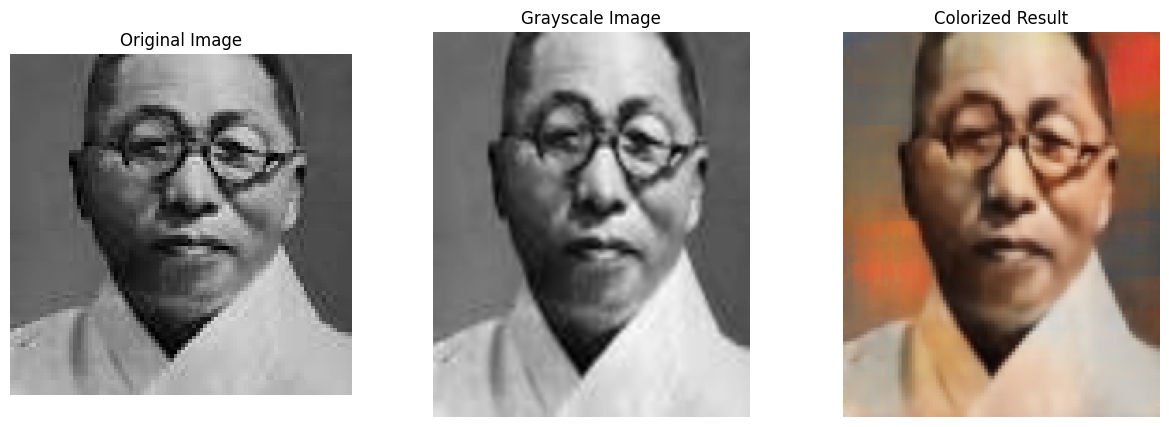

In [ ]:
#컬러화만 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(color_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Grayscale Image')
plt.imshow(preprocessed_image[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Colorized Result')
plt.imshow(colorized_image[0])
plt.axis('off')

plt.show()

In [ ]:
colorized_image = (colorized_image[0] * 255).astype(np.uint8)

# 컬러화 결과 저장
colorized_result_path = "/content/colorized_result.jpg"
cv2.imwrite(colorized_result_path, cv2.cvtColor(colorized_image, cv2.COLOR_RGB2BGR))

print(f"Colorized result saved to {colorized_result_path}")

Colorized result saved to /content/colorized_result.jpg


In [20]:
#컬러화 이미지 업로드
upload_folder = 'inputs/upload'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
os.mkdir(upload_folder)


uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)


Saving colorized_result (1).jpg to colorized_result (1).jpg
move colorized_result (1).jpg to inputs/upload/colorized_result (1).jpg


In [17]:
!rm -rf results
!python inference_gfpgan.py -i inputs/upload -o results -v 1.3 -s 2 --bg_upsampler realesrgan

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/content/GFPGAN/inference_gfpgan.py:63: UserWarning: The unoptimized RealESRGAN is slow on CPU. We do not use it. If you really want to use it, please modify the corresponding codes.
  warnings.warn('The unoptimized RealESRGAN is slow on CPU. We do not use it. '
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are de

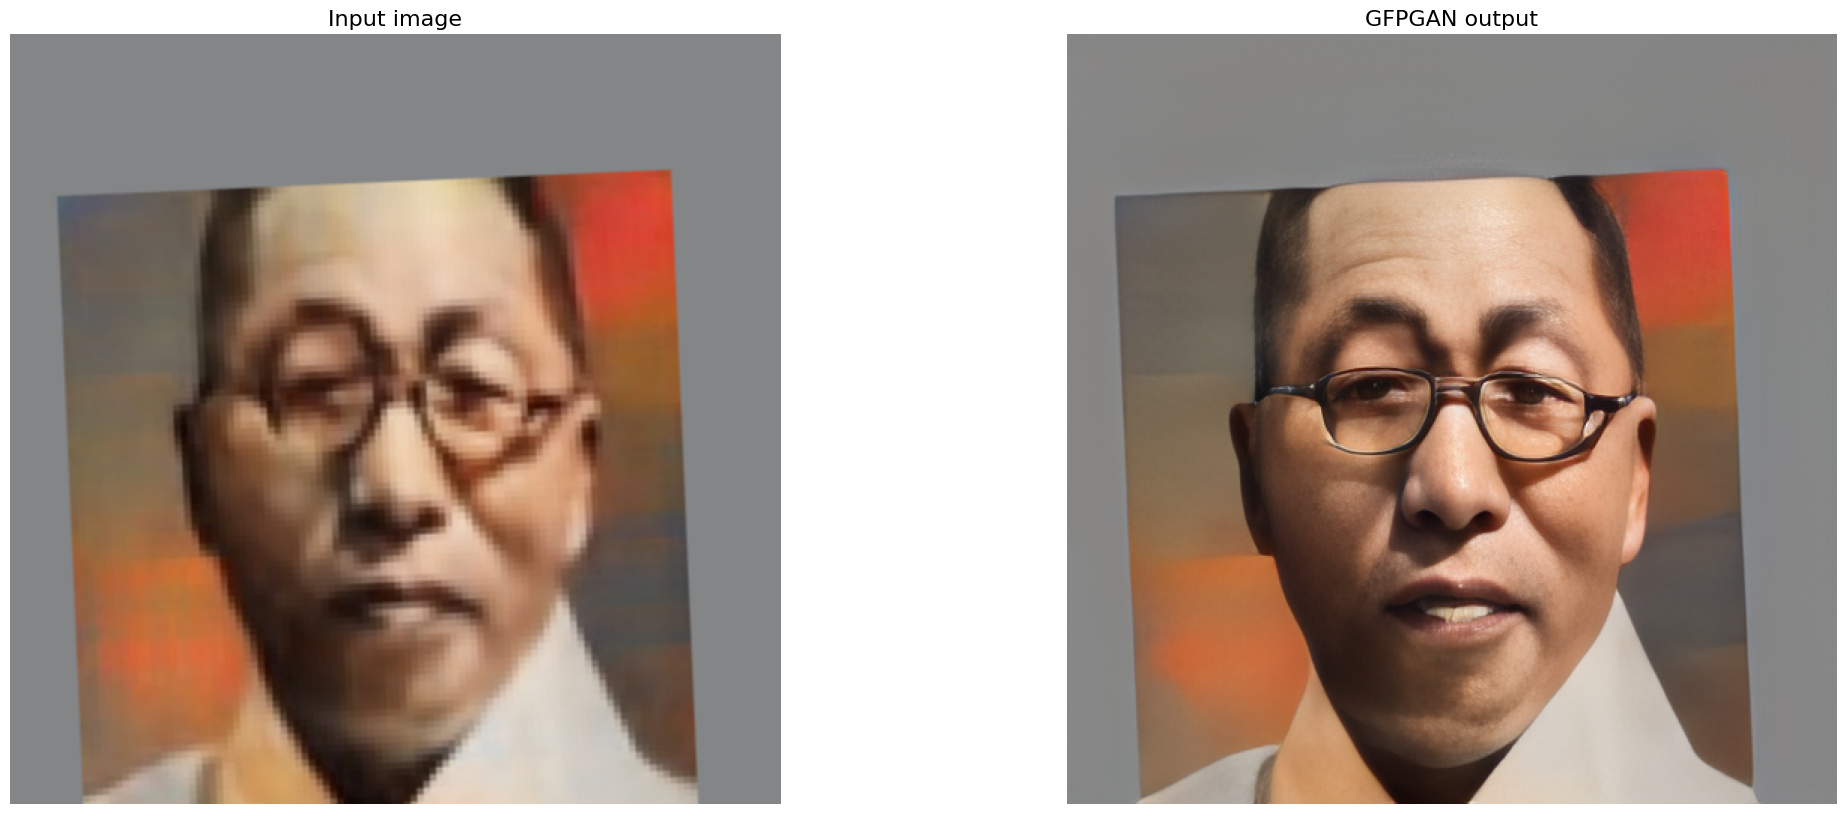

In [18]:
#컬러화&복원 결과 시각화

def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('GFPGAN output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)
def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

input_folder = 'results/cropped_faces'
result_folder = 'results/restored_faces'
input_list = sorted(glob.glob(os.path.join(input_folder, '*')))
output_list = sorted(glob.glob(os.path.join(result_folder, '*')))
for input_path, output_path in zip(input_list, output_list):
  img_input = imread(input_path)
  img_output = imread(output_path)
  display(img_input, img_output)